# Imports and Data Preparation

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Imports for time series analysis
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports for regression
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Imports for evaluation
from sklearn.metrics import r2_score

# Imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from IPython.display import Image

In [2]:
df = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=';', decimal=",")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')

# Shift moving averages because values are not known at time of prediction
for c in df.columns:
    if "avg" in c or "max" in c:
        df[c+"_shifted"] = df[c].shift(24)
        df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00", c+"_shifted"] = 0 # to avoid NaN value
        
for c in df.columns:
    if ("solar" in c) | ("total" in c):
        df.drop(c, axis=1, inplace=True)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        df.drop(c, axis=1, inplace=True)

df.columns

Index(['hour', 'day_ahead_price', 'intraday_price', 'price_diff',
       'wind_capacity', 'wind_generation_actual', 'wind_generation_forecast',
       'wind_forecast_error', 'forecast_error', 'season', 'month', 'weekday',
       'mov_avg_30_forecast_error_shifted',
       'mov_avg_30_wind_forecast_error_shifted',
       'mov_avg_10_forecast_error_shifted',
       'mov_avg_10_wind_forecast_error_shifted',
       'mov_avg_1_forecast_error_shifted',
       'mov_avg_1_wind_forecast_error_shifted', 'mov_avg_1_day_ahead_shifted',
       'mov_avg_1_intraday_shifted', 'wind_24h_max_shifted',
       'hourly_moving_avg_wind_shifted', 'hourly_moving_avg_2_wind_shifted',
       'hourly_moving_avg_7_wind_shifted'],
      dtype='object')

# Testing two options for forecast error prediction

### Thoughts on evaluation

By default cross_val_score seems to calculate the coefficient of determination (R^2) for regression instead of accuracy (https://www.quora.com/What-does-sklearn-cross_val_score-do-in-a-regression-problem). Recall: Acurracy measures if the class has been predicted correctly or not.

According to scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) the follwing metrics are appropriate for regression:

 - Explained variance score ('explained_variance')
 - Mean absolute error ('neg_mean_absolute_error')
 - Mean squared error ('neg_mean_squared_error')
 - Mean squared logarithmic error ('neg_mean_squared_log_error')
 - Median absolute error ('neg_median_absolute_error')
 - R² score, the coefficient of determination ('r2')

Calulating Mean Squared Logarithmic Error yields the following error: "Mean Squared Logarithmic Error cannot be used when targets contain negative values." Thus it is not used for evaluation.

In [3]:
# Dict containing the scorers to be used
scoring = {'explained_variance': 'explained_variance',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'r2': 'r2'
          }

# Function which returns a table with scores achieved with different parameters
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["expl_var",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "r2"]
    scores_df["expl_var"] = scores_df["expl_var"].round(4)
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["r2"] = scores_df["r2"].round(4)
    return scores_df

## Classical Predictors

In this option we assume the forecast error does not depend on a specific point in time (e.g. 07-07-2016 13:00). Thus we can use classical ML models (e.g. Regression Trees) and classical CV instead of TimeSeriesSplit. Nevertheless, we explicitly can use moving averages and shifted values.

### Splitting into dependent and independent variables
First, the dataset will be splitted into dependent (the ones used for prediction) and independent variables (the one to be predicted).

In [5]:
# Set with which features the prediction should be made and with feature should be predicted
y = df.wind_forecast_error
X = df.drop([
             # What we want to predict
             "wind_forecast_error",
             "forecast_error",
    
             # Not known then
             "wind_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff",
            ], axis=1)
X = X.reset_index()
X = X.drop("datetime", axis=1)
len(X.columns)

18

### Splitting into training and test sets

Sedond, the dataset will be splitted into a training and a test part. The first one is used for hyperparameter tuning and CV, the second one is used as holdout set for final evaluation. Since we assume the forecast error not depending on a specific point in time, we can split the whole dataset randomly.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model 1: Decision Tree Regressor

In [7]:
scores_list = []
param_range = range(3,30)

for i in param_range:
    DTR = DecisionTreeRegressor(max_depth=i)
    scores_list.append(cross_validate(DTR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.0407,1054.02,2163447.2,752.327,0.0406
4,0.0632,1047.50,2111124.1,751.019,0.0632
5,0.0803,1037.24,2072074.3,750.296,0.0803
6,0.1032,1023.86,2020873.8,738.649,0.1030
7,0.1327,1006.42,1954427.5,726.263,0.1326
8,0.1624,989.86,1888058.8,716.915,0.1623
9,0.1824,976.57,1843393.9,708.027,0.1823
10,0.2069,957.86,1787897.0,690.954,0.2068
11,0.2271,940.65,1742404.5,675.759,0.2269
12,0.2595,914.64,1668864.4,644.162,0.2594


In [10]:
# Final Evaluation

DTR = DecisionTreeRegressor(max_depth=28)
DTR.fit(X_train, y_train)
y_pred = DTR.predict(X_test)
r2_score(y_test, y_pred)

0.6489800367180338

### Model 2: Random Forest Regressor

In [20]:
param_grid = {'max_depth': range(45, 55),
              #'min_samples_split': range(2,5),
              #'min_samples_leaf': range(1,10),
              #'max_features': ["auto", "sqrt","log2"]
              #'n_estimators': [10, 20, 50, 100]
             }

RFR = RandomForestRegressor(random_state=42, n_estimators=100)

grid = GridSearchCV(estimator=RFR,
                    param_grid=param_grid,
                    scoring="r2",
                    refit="r2",
                    return_train_score=False,
                    n_jobs=-1,
                    cv=5
                   )

In [21]:
grid.fit(X_train, y_train)
best_plist = grid.best_params_
print(best_plist)

{'max_depth': 47}


In [22]:
grid.best_score_

0.7780726228449375

In [23]:
# Investigation of values around best_params_

scores_list = []
param_range = range(25,55)

for depth in param_range:
    RFR = RandomForestRegressor(max_depth=depth, n_estimators=100, n_jobs=-1)
    scores_list.append(cross_validate(RFR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
25,0.7605,504.93,539894.0,342.810,0.7604
26,0.7644,498.01,531008.0,335.869,0.7644
27,0.7681,492.79,522608.2,331.392,0.7680
28,0.7704,489.07,517456.8,329.231,0.7704
29,0.7724,486.37,512919.4,323.670,0.7723
30,0.7735,483.79,510449.0,321.772,0.7734
31,0.7748,482.51,507653.6,320.107,0.7747
32,0.7758,481.34,505133.3,320.882,0.7758
33,0.7751,481.77,506835.4,318.514,0.7750
34,0.7754,481.03,506055.8,320.076,0.7754


Since the first time when 0.776X appears and the creation of deeper trees takes considerable more time, we decide to use the depth 35 with an r2 score of 0.7762.

In [24]:
# Final Evaluation

RFR = RandomForestRegressor(max_depth=35,
                            n_estimators=100,
                            min_samples_split=2, # i.e. default
                            min_samples_leaf=1, # i.e. default
                            max_features="auto" # i.e. default
                           )
RFR.fit(X_train, y_train)
y_pred = RFR.predict(X_test)
r2_score(y_test, y_pred)

0.8307422411678604

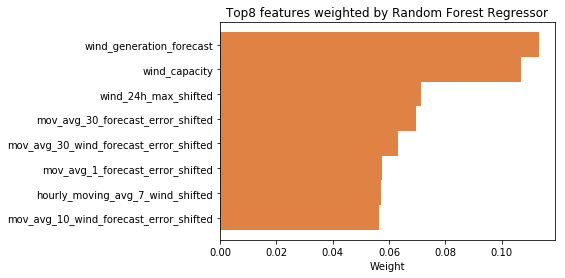

[(0.0565, 'mov_avg_10_wind_forecast_error_shifted'),
 (0.0572, 'hourly_moving_avg_7_wind_shifted'),
 (0.0575, 'mov_avg_1_forecast_error_shifted'),
 (0.063, 'mov_avg_30_wind_forecast_error_shifted'),
 (0.0697, 'mov_avg_30_forecast_error_shifted'),
 (0.0715, 'wind_24h_max_shifted'),
 (0.107, 'wind_capacity'),
 (0.1132, 'wind_generation_forecast')]

In [39]:
# See how important the features of the data frame are for the prediction with Random Forests

RFR = RandomForestRegressor(max_depth=35, n_estimators=100)
RFR.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X.columns), reverse=True)
features = features[0:8]
features = features[::-1]
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.barh(xs, ys, width, align='center', color='#df8244')
plt.yticks(xs, labels) #rotation='vertical'
plt.title("Top8 features weighted by Random Forest Regressor")
plt.xlabel("Weight")
plt.show()
features

### Model 3: Ridge Regression

In [29]:
scores_list = []
param_range = (0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)

for alpha in param_range:
    RR = Ridge(alpha=alpha)
    scores_list.append(cross_validate(RR, X_train, y_train, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
0.1,0.0252,1062.83,2198923.6,763.183,0.0252
1.0,0.0252,1062.83,2198923.6,763.183,0.0252
10.0,0.0252,1062.83,2198923.2,763.187,0.0252
100.0,0.0252,1062.83,2198919.6,763.186,0.0252
1000.0,0.0253,1062.85,2198896.0,763.120,0.0252
10000.0,0.0252,1062.90,2198947.7,764.090,0.0252
100000.0,0.0248,1062.80,2199833.7,764.420,0.0248
1000000.0,0.0235,1062.79,2202826.0,760.960,0.0235
10000000.0,0.0223,1062.71,2205534.3,760.688,0.0222
100000000.0,0.0219,1062.50,2206586.7,758.239,0.0218


In [30]:
# Final Evaluation

RR = Ridge(alpha=100000)
RR.fit(X_train, y_train)
y_pred = RR.predict(X_test)
r2_score(y_test, y_pred)

0.02745052421779326